In [1]:
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import expr
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from helpers.helper_functions import translate_to_file_string
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
# for pretty printing
def printDf(sprkDF): 
    newdf = sprkDF.toPandas()
    from IPython.display import display, HTML
    return HTML(newdf.to_html())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
inputFile = translate_to_file_string("../data/heart.csv")

In [3]:
spark = (SparkSession
       .builder
       .appName("HeartDiseaseAnal")
       .getOrCreate())

In [4]:
# load data file.
# create a DataFrame using an ifered Schema 
df = spark.read.option("header", "true") \
       .option("inferSchema", "true") \
       .option("delimiter", ",") \
       .csv(inputFile)
print(df.printSchema())

#Pandas df for visualization
dfp = df.toPandas()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)

None


In [5]:
# Show summary of data
printDf(df.summary())

,summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,count,303,303,303,303,303,303,303,303,303,303,303,303,303,303
1,mean,54.366336633663366,0.6831683168316832,0.966996699669967,131.62376237623764,246.26402640264027,0.1485148514851485,0.528052805280528,149.64686468646866,0.32673267326732675,1.0396039603960396,1.3993399339933994,0.7293729372937293,2.3135313531353137,0.5445544554455446
2,stddev,9.08210098983786,0.46601082333962385,1.0320524894832983,17.5381428135171,51.83075098793005,0.35619787492797644,0.525859596359298,22.90516111491409,0.46979446452231655,1.1610750220686346,0.6162261453459622,1.0226063649693276,0.6122765072781408,0.4988347841643915
3,min,29,0,0,94,126,0,0,71,0,0.0,0,0,0,0
4,25%,47,0,0,120,211,0,0,133,0,0.0,1,0,2,0
5,50%,55,1,1,130,240,0,1,153,0,0.8,1,0,2,1
6,75%,61,1,2,140,275,0,1,166,1,1.6,2,1,3,1
7,max,77,1,3,200,564,1,2,202,1,6.2,2,4,3,1


In [6]:
age_groups = pd.cut(dfp['age'], bins=[20, 30,40,50,60,70,80,90])
pd.crosstab(age_groups, dfp['sex'])

sex,0,1
age,,
"(20, 30]",0,1
"(30, 40]",5,13
"(40, 50]",22,54
"(50, 60]",35,94
"(60, 70]",29,44
"(70, 80]",5,1


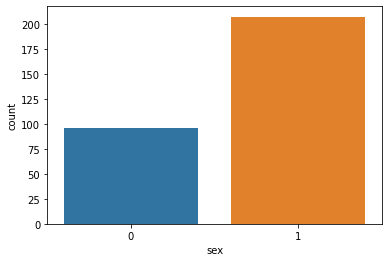

In [7]:
dfp.sex.value_counts()
#Sex (1 = male; 0 = female)
sns.countplot(dfp.sex)
plt.show()

Saving figure attribute_box_plots


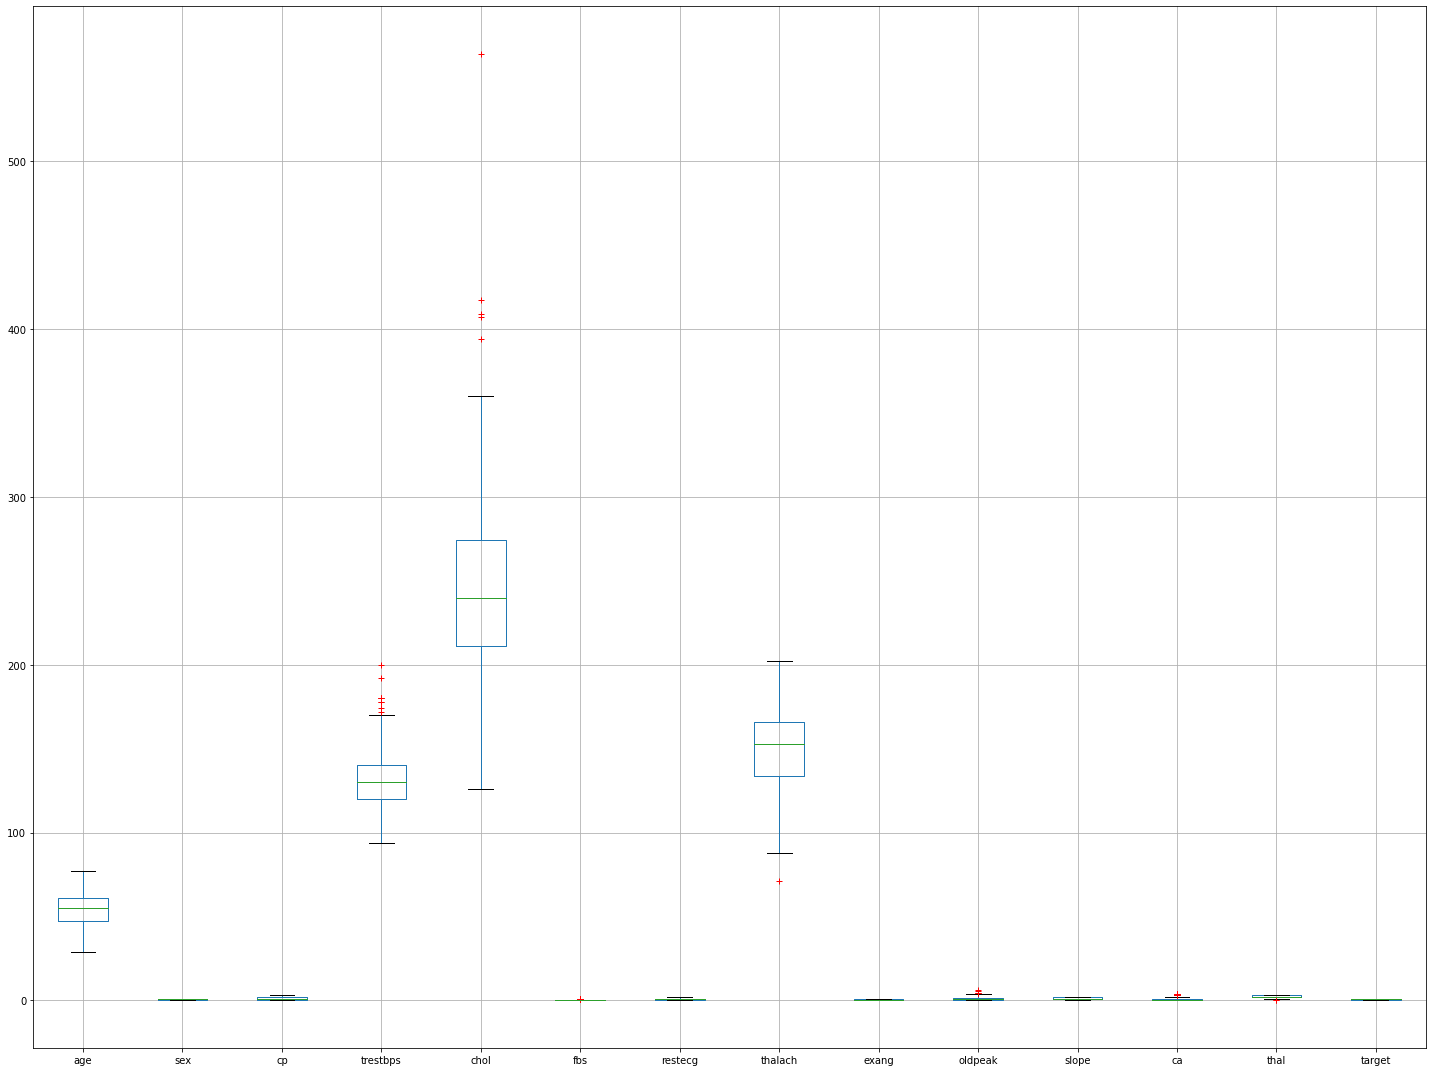

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
df.toPandas().boxplot(sym='r+', figsize=(20,15))
save_fig("attribute_box_plots")
plt.show()

Saving figure attribute_density_plots


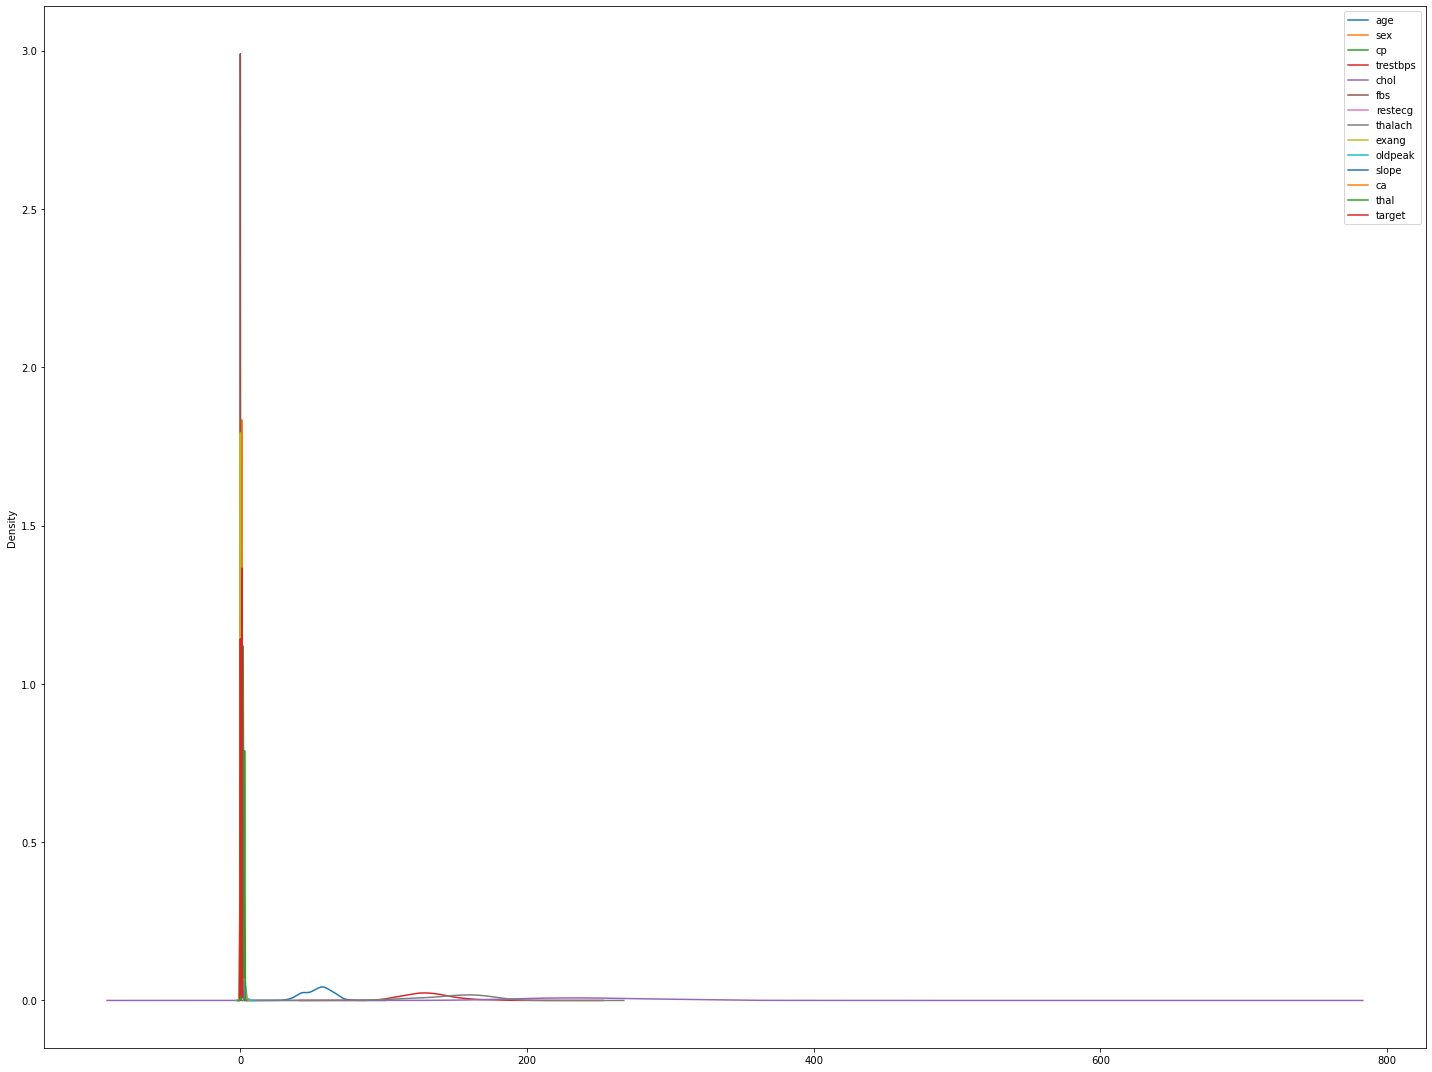

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
df.toPandas().plot.kde(figsize=(20,15))
save_fig("attribute_density_plots")
plt.show()

Saving figure attribute_histogram_plots


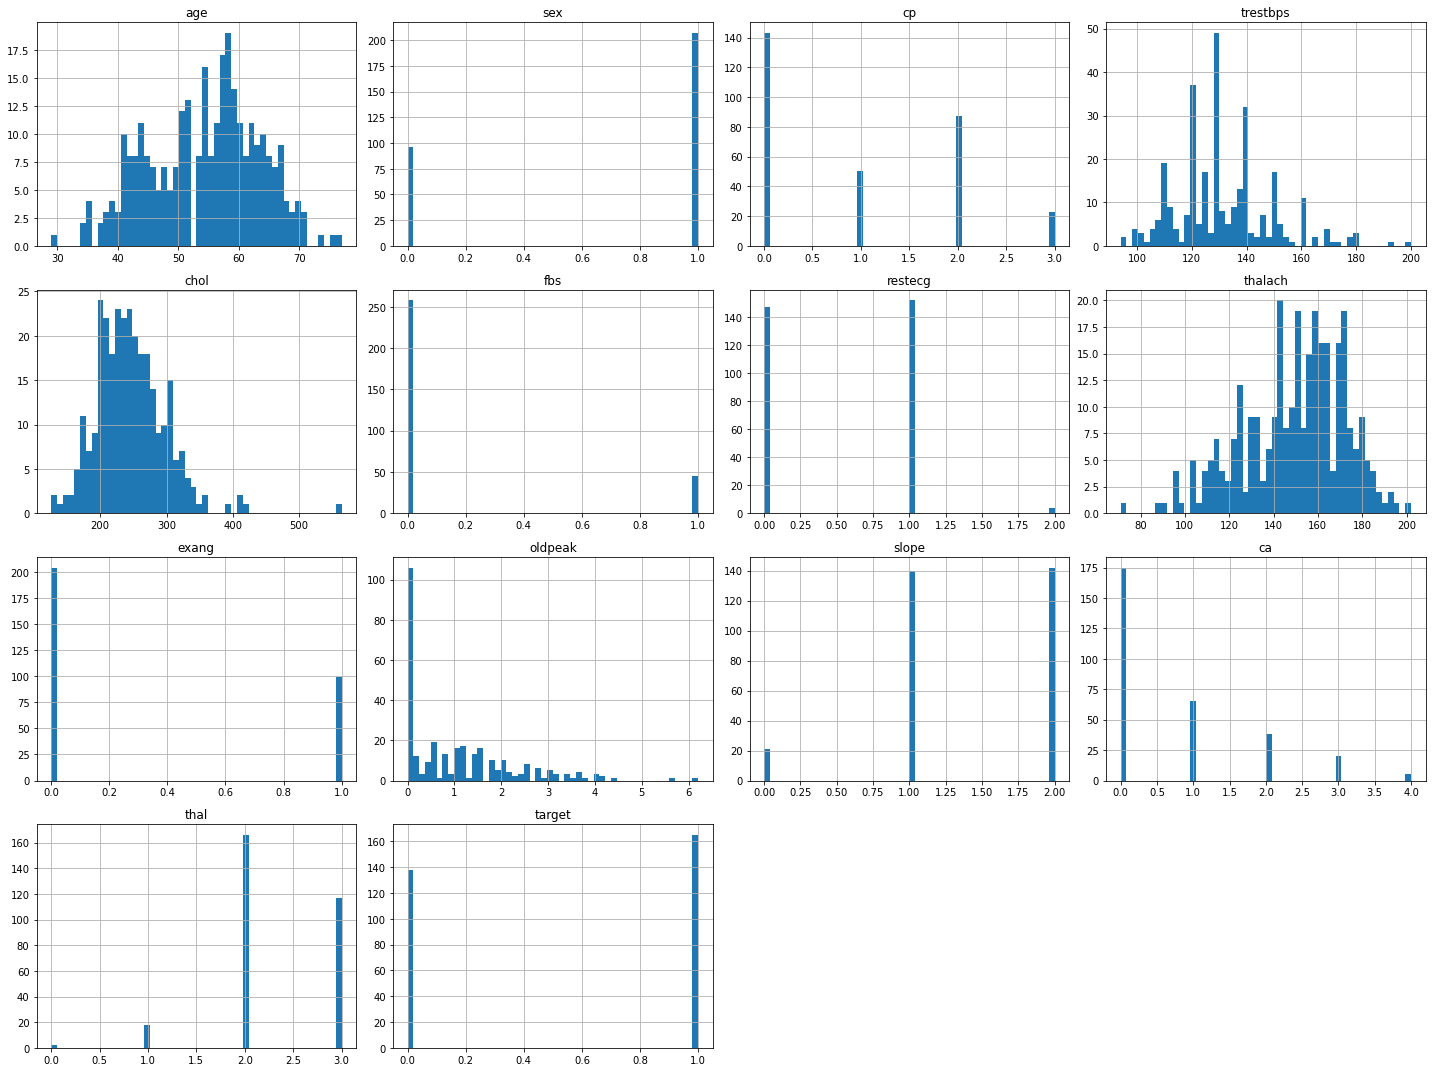

In [10]:
dfp.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [11]:
#transform labels
labelIndexer = StringIndexer().setInputCol("target").setOutputCol("label").fit(df)

In [12]:
#feature cols- die spalten die interessieren, auch gerne entfernen für tests
featureCols = df.columns.copy()
#featureCols.remove("SpalteXY")

In [13]:
#vektor assembler
assembler =  VectorAssembler(outputCol="features", inputCols=list(featureCols))

In [14]:
#Build decistion tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

TypeError: __init__() got an unexpected keyword argument 'labelCol'

In [ ]:
# build a network para grip
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [ 5, 10 ]) \
				              .addGrid(dt.minInfoGain, [0.05, 0.025, 0.02, 0.01]) \
				              .addGrid(dt.minInstancesPerNode, [5, 10, 15]) \
                              .addGrid(dt.maxBins, [5, 6, 9]) \
				              .build()

In [ ]:
#split data for etsting

splits = df.randomSplit([0.6, 0.4 ], 1234)
train = splits[0]
test = splits[1]

In [ ]:
#Pipelining of all steps 
pipeline = Pipeline(stages= [labelIndexer, assembler, featureIndexer,  dt])

In [ ]:
#build evaluator 


In [ ]:
evaluator =  BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [ ]:
#Cross validator
cv = CrossValidator(estimator=pipeline, evaluator=evaluator,estimatorParamMaps=paramGrid,numFolds=10, parallelism=2)

In [ ]:
#train modle
cvModel = cv.fit(train)